In [1]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import matplotlib.pylab as plt
# %matplotlib widget
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
# Classifier from TF hub
import numpy as np

classifier_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4'
IMAGE_SHAPE = (96, 96)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3, )) # Channel 3 RGB
])

## And labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [3]:
# prepare dataset
dataset_root = os.path.abspath(os.path.expanduser('./img_data/'))
print(f'Dataset root: {dataset_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.1)
train_data = image_generator.flow_from_directory(dataset_root, target_size=IMAGE_SHAPE,
                                                 subset='training')
validation_data = image_generator.flow_from_directory(dataset_root, target_size=IMAGE_SHAPE,
                                                 subset='validation')

for image_batch, label_batch in validation_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Dataset root: /home/harny/Github/tff-app/img_data.tar.gz


NotADirectoryError: [Errno 20] Not a directory: '/home/harny/Github/tff-app/img_data.tar.gz'

Batch result shape: (32, 1001)
Batch predicted class names: ['crossword puzzle' 'crossword puzzle' 'digital clock' 'crossword puzzle'
 'crossword puzzle' 'crossword puzzle' 'crossword puzzle' 'dishwasher'
 'jigsaw puzzle' 'crossword puzzle' 'chain' 'jigsaw puzzle'
 'crossword puzzle' 'crossword puzzle' 'jigsaw puzzle' 'strainer'
 'jigsaw puzzle' 'crossword puzzle' 'crossword puzzle' 'jigsaw puzzle'
 'jigsaw puzzle' 'strainer' 'crossword puzzle' 'jigsaw puzzle'
 'crossword puzzle' 'crossword puzzle' 'crossword puzzle'
 'crossword puzzle' 'crossword puzzle' 'crossword puzzle' 'jigsaw puzzle'
 'dishwasher']


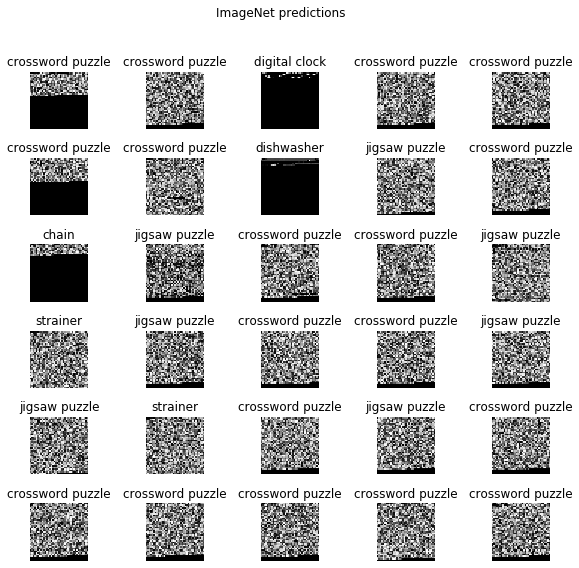

In [4]:
# Predict batch input example
## using original ImangeNet classifier

import PIL.Image as Image

result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

fig1 = plt.figure(figsize=(10, 9))
fig1.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig1.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    ax.set_title(predicted_class_names[n])
    ax.axis('off')
_ = fig1.suptitle('ImageNet predictions')

In [5]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3, ))
feature_batch = feature_extractor_layer(image_batch)
print(f'Feature vector shape: {feature_batch.shape}')

## Frozen feature extraction layer
feature_extractor_layer.trainable = False # for transfer learning classifier

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(train_data.num_classes, activation='softmax')
])

Feature vector shape: (32, 1280)


In [6]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 20,496
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape: (32, 16)


In [7]:
# Train build
## Compile model for train
base_learning_rate = 0.001 # default
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss='categorical_crossentropy',
    metrics=['acc'])

## Log class
### https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        self.batch_acc = []
        self.batch_val_acc = []

#     def on_train_batch_end(self, batch, logs=None):
#         self.batch_losses.append(logs['loss'])
#         self.batch_acc.append(logs['acc'])
#         self.model.reset_metrics()
    
#     def on_test_batch_end(self, batch, logs=None):
#         self.batch_val_losses.append(logs['loss'])
#         self.batch_val_acc.append(logs['acc'])
#         self.model.reset_metrics()
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_acc'])
        self.model.reset_metrics()

In [8]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 20
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_data,  
                              epochs=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_data,
                              callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 7342.0 steps, validate for 816 steps
Epoch 1/20
7342/7342 [==============================] - 636s 87ms/step - loss: 1.3329 - acc: 0.5411 - val_loss: 1.3295 - val_acc: 0.5390
Epoch 2/20
7342/7342 [==============================] - 645s 88ms/step - loss: 1.2406 - acc: 0.5659 - val_loss: 1.2930 - val_acc: 0.5880
Epoch 3/20
7342/7342 [==============================] - 647s 88ms/step - loss: 1.2166 - acc: 0.5710 - val_loss: 1.3200 - val_acc: 0.5817
Epoch 4/20
7342/7342 [==============================] - 632s 86ms/step - loss: 1.2025 - acc: 0.5752 - val_loss: 1.3037 - val_acc: 0.5910
Epoch 5/20
7342/7342 [==============================] - 649s 88ms/step - loss: 1.1941 - acc: 0.5783 - val_loss: 1.3322 - val_acc: 0.5662
Epoch 6/20
7342/7342 [==============================] - 651s 89ms/step - loss: 1.1855 - acc: 0.5798 - val_loss: 1.3009 - val_acc: 0.5971
Epoch 7/20
7342/7342 [==============================] - 635s 86ms/step - loss: 1.1809 - acc: 0.5805 - val_loss: 1.3131 - val_acc: 0

Text(0.5, 0, 'epoch')

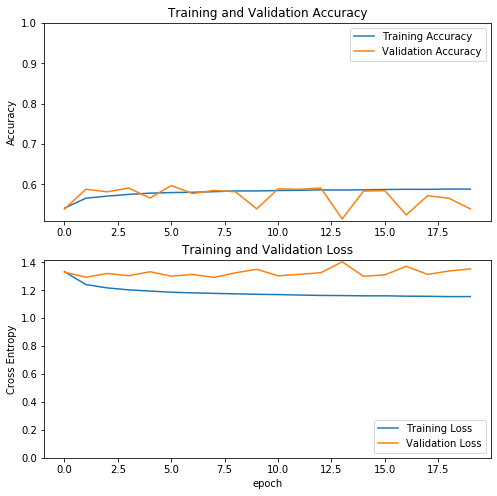

In [9]:
# Draw learning curves chart
acc = batch_stats_callback.batch_acc
val_acc = batch_stats_callback.batch_val_acc
loss = batch_stats_callback.batch_losses
val_loss = batch_stats_callback.batch_val_losses

fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='upper right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(ax1.get_ylim()),1])
ax1.set_title('Training and Validation Accuracy')

ax2 = fig2.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='lower right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Aim' 'Email' 'Facebook' 'Ftps' 'Gmail' 'Hangout' 'Icqchat' 'Netflix'
 'Scp' 'Sftp' 'Skype' 'Spotify' 'Torrent' 'Vimeo' 'Voipbuster' 'Youtube']


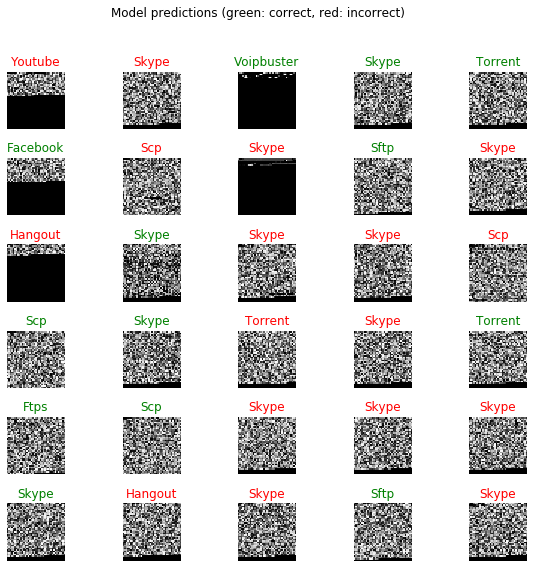

In [10]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig3 = plt.figure(figsize=(10,9))
fig3.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig3.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig3.suptitle('Model predictions (green: correct, red: incorrect)')

In [11]:
# Export model
import time
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_models/1581328112/assets


INFO:tensorflow:Assets written to: ./saved_models/1581328112/assets


Export the model to ./saved_models/1581328112


In [12]:
# Check the exported model
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0


In [13]:
## Unfrozen feature extraction layer
feature_extractor_layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
Total params: 2,278,480
Trainable params: 2,244,368
Non-trainable params: 34,112
_________________________________________________________________


In [14]:
finetune_epoch = 40

history_fine = model.fit_generator(train_data,
                                   epochs=initial_epoch+finetune_epoch,
                                   initial_epoch=initial_epoch, # == history.epoch[-1]+1
                                   steps_per_epoch=steps_per_epoch,
                                   validation_data=validation_data,
                                   callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 7342.0 steps, validate for 816 steps
Epoch 21/60
7342/7342 [==============================] - 2902s 395ms/step - loss: 1.5012 - acc: 0.5990 - val_loss: 0.9973 - val_acc: 0.6955
Epoch 22/60
7342/7342 [==============================] - 3078s 419ms/step - loss: 0.4505 - acc: 0.8767 - val_loss: 0.6944 - val_acc: 0.8235
Epoch 23/60
7342/7342 [==============================] - 2905s 396ms/step - loss: 0.2691 - acc: 0.9338 - val_loss: 0.5987 - val_acc: 0.8677
Epoch 24/60
7342/7342 [==============================] - 2904s 396ms/step - loss: 0.2138 - acc: 0.9516 - val_loss: 0.7037 - val_acc: 0.8806
Epoch 25/60
7342/7342 [==============================] - 2854s 389ms/step - loss: 0.1883 - acc: 0.9600 - val_loss: 0.6532 - val_acc: 0.8970
Epoch 26/60
7342/7342 [==============================] - 2867s 390ms/step - loss: 0.1702 - acc: 0.9657 - val_loss: 0.7511 - val_acc: 0.8671
Epoch 27/60
7342/7342 [==============================] - 2862s 390ms/step - loss: 0.1575 - acc: 0.9698 - val_loss

KeyError: 'val_loss'

Text(0.5, 0, 'epoch')

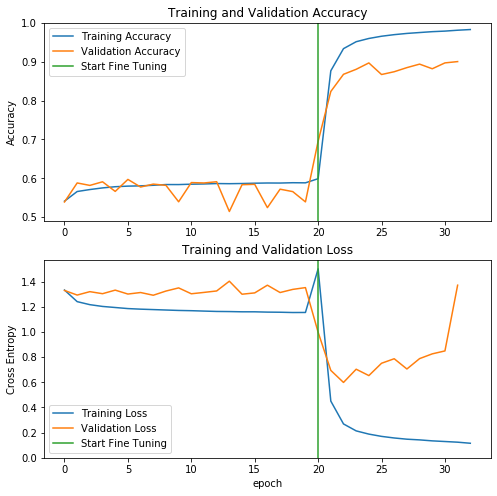

In [17]:
# Draw learning curves chart
fine_acc = batch_stats_callback.batch_acc
fine_val_acc = batch_stats_callback.batch_val_acc
fine_loss = batch_stats_callback.batch_losses
fine_val_loss = batch_stats_callback.batch_val_losses

fig4 = plt.figure(figsize=(8, 8))
ax1 = fig4.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(ax1.get_ylim()),1])
ax1.plot([initial_epoch,initial_epoch],
         ax1.get_ylim(), label='Start Fine Tuning')
ax1.legend(loc='upper left')
ax1.set_title('Training and Validation Accuracy')

ax2 = fig4.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.plot([initial_epoch,initial_epoch],
         ax2.get_ylim(), label='Start Fine Tuning')
ax2.legend(loc='lower left')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

Classes: ['Aim' 'Email' 'Facebook' 'Ftps' 'Gmail' 'Hangout' 'Icqchat' 'Netflix'
 'Scp' 'Sftp' 'Skype' 'Spotify' 'Torrent' 'Vimeo' 'Voipbuster' 'Youtube']


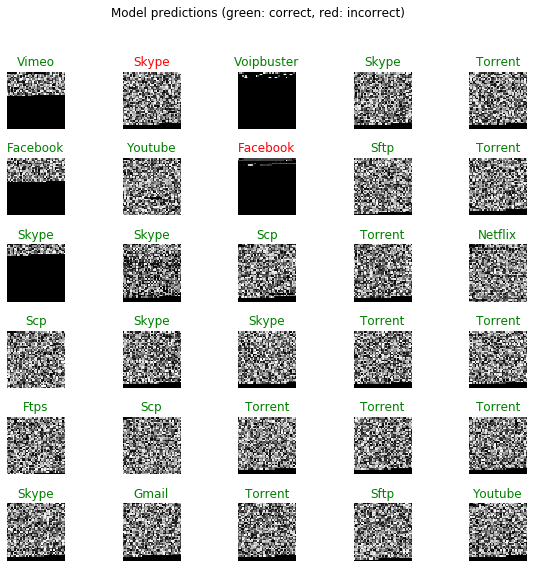

In [18]:
# Plot results
class_names = sorted(validation_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig5 = plt.figure(figsize=(10,9))
fig5.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig5.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig5.suptitle('Model predictions (green: correct, red: incorrect)')

In [19]:
# Export model too
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

INFO:tensorflow:Assets written to: ./saved_models/1581372191/assets


INFO:tensorflow:Assets written to: ./saved_models/1581372191/assets


Export the model to ./saved_models/1581372191


In [ ]:
# Check the exported model too
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')